            Date/Time      Lat      Lon    Base  DayOfWeekNum DayOfWeek  \
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512             1   Tuesday   
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512             1   Tuesday   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512             1   Tuesday   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512             1   Tuesday   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512             1   Tuesday   

   MonthDayNum  HourOfDay  
0            1          0  
1            1          0  
2            1          0  
3            1          0  
4            1          0  


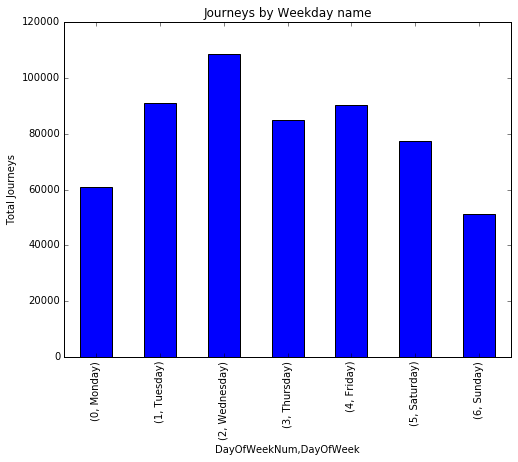

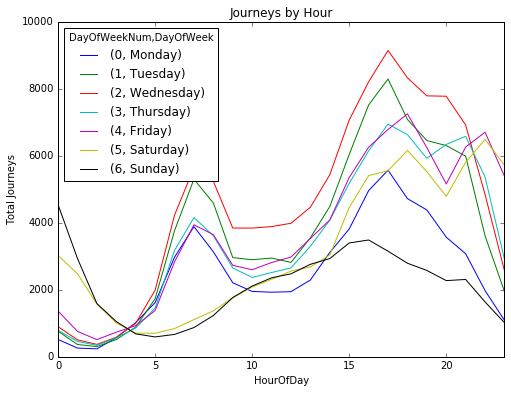

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

uber_data_apr14 = pd.read_csv("uber-raw-data-apr14.csv")

# split the time feature from Date/Time
uber_data_apr14['Date/Time'] = pd.to_datetime(uber_data_apr14['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_data_apr14['DayOfWeekNum'] = uber_data_apr14['Date/Time'].dt.dayofweek # By doing this we can order the weekday name
uber_data_apr14['DayOfWeek'] = uber_data_apr14['Date/Time'].dt.weekday_name
uber_data_apr14['MonthDayNum'] = uber_data_apr14['Date/Time'].dt.day
uber_data_apr14['HourOfDay'] = uber_data_apr14['Date/Time'].dt.hour

#show the structure of uber_data_apr14 now
uber_data_apr14.head()

uber_hour_apr14 = uber_data_apr14.pivot_table(index=['DayOfWeekNum','DayOfWeek'],values='Base',aggfunc='count')
uber_hour_apr14.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Weekday name');

uber_hour_apr14 = uber_data_apr14.pivot_table(index=['HourOfDay'],columns=['DayOfWeekNum','DayOfWeek'],values='Base',aggfunc='count')
uber_hour_apr14.plot(kind='line', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Hour');



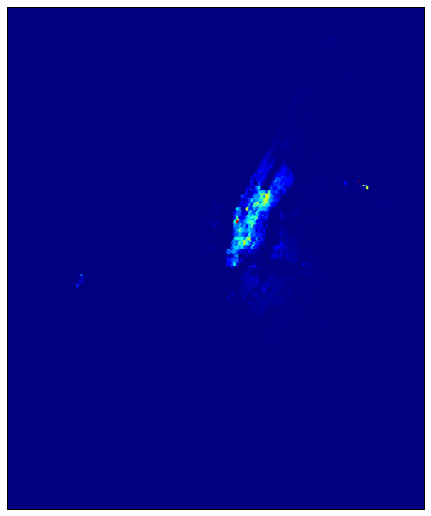

In [105]:
# do the spatial visulization
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

fig = plt.figure(figsize=(12,9))
m = Basemap(projection='merc',llcrnrlon=-74.26, urcrnrlon=-73.80,llcrnrlat=40.50,urcrnrlat=40.92)
x, y = m(uber_data_apr14['Lon'].values, uber_data_apr14['Lat'].values)
m.hexbin(x, y, gridsize=1000)

In [71]:
# Prediction Part 1
# Multiple Linear Regression
from sklearn import linear_model
import random
from sklearn.metrics import mean_squared_error

clf = linear_model.LinearRegression()
uber_data_feature_index=['Lat','Lon','DayOfWeekNum','MonthDayNum','HourOfDay']
uber_data_apr14_feature=uber_data_apr14[uber_data_feature_index]
uber_data_apr14_count = uber_data_apr14.pivot_table(index=['Lat','Lon','DayOfWeekNum','MonthDayNum','HourOfDay'],values='Base',aggfunc='count')
uber_data_apr14_feature.head()

# get the training data
length=len(uber_data_apr14_feature)
#randomlist=random.sample(range(0,length),2000)

clf.fit(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
clf.score(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
print('Coefficient: \n',clf.coef_)
print('Intercept: \n',clf.intercept_)
predictedclf=clf.predict(uber_data_apr14_feature[2000:3000])
mlrmse = mean_squared_error(uber_hour_apr14_count[2000:3000], predictedclf[0:1000])
print('the MSE of multiple Linear Regression is: ',mlrmse)

Coefficient: 
 [-0.08900857 -0.04803921  0.00407449  0.00407449 -0.00018701]
Intercept: 
 1.07716841622
the MSE of multiple Linear Regression is:  0.0120313574717


In [78]:
# Ridge Regression
from sklearn.linear_model import Ridge

clfridge = Ridge(alpha=1.0)
clfridge.fit(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000]) 
clfridge.score(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
print('Coefficient: \n',clfridge.coef_)
print('Intercept: \n',clfridge.intercept_)
predictedrclf=clfridge.predict(uber_data_apr14_feature[2000:3000])
clfrmse = mean_squared_error(uber_hour_apr14_count[2000:3000], predictedrclf[0:1000])
print('the MSE of Ridge Regression is: ',clfrmse)


Coefficient: 
 [-0.06062736 -0.04260266  0.0040641   0.0040641  -0.00017661]
Intercept: 
 0.322775984407
the MSE of Ridge Regression is:  0.0120194298265


In [82]:
# Lasso Regression
from sklearn.linear_model import Lasso

clflasso = Lasso(alpha=0.0001)
clflasso.fit(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000]) 
clflasso.score(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
print('Coefficient: \n',clflasso.coef_)
print('Intercept: \n',clflasso.intercept_)
predictedlclf=clflasso.predict(uber_data_apr14_feature[2000:3000])
clflmse = mean_squared_error(uber_hour_apr14_count[2000:3000], predictedlclf[0:1000])
print('the MSE of Lasso Regression is: ',clflmse)

Coefficient: 
 [ -0.00000000e+00  -1.89417083e-02   7.66384405e-03   4.77453672e-18
  -1.60532818e-04]
Intercept: 
 -0.396731536947
the MSE of Lasso Regression is:  0.0119866062604


In [74]:
# Prediction Part 2
# k-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
predictedknn=knn.predict(uber_data_apr14_feature[2000:3000])
knnmse = mean_squared_error(uber_hour_apr14_count[2000:3000], predictedknn[0:1000])
print('the MSE of K-NN is: ',knnmse)


the MSE of K-NN is:  0.012


In [76]:
# Prediction Part 3
# Decision trees
from sklearn import tree
from sklearn.metrics import mean_squared_error

decisiontree=tree.DecisionTreeClassifier(criterion='gini')
decisiontree.fit(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
decisiontree.score(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
predictedtree=decisiontree.predict(uber_data_apr14_feature[2000:3000])
treemse = mean_squared_error(uber_hour_apr14_count[2000:3000], predictedtree[0:1000])
print('the MSE of decision tree is: ',treemse)

the MSE of decision tree is:  0.041


In [83]:
# Prediction Part 4
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(uber_data_apr14_feature[:2000],uber_hour_apr14_count[:2000])
predictedgnb=gnb.predict(uber_data_apr14_feature[2000:3000])
gnbmse = mean_squared_error(uber_hour_apr14_count[2000:3000], predictedgnb[0:1000])
print('the MSE of Naive Bayes is: ',gnbmse)

the MSE of Naive Bayes is:  0.012
